**Import Libraries**

In [ ]:
#!pip install plotly
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA
import requests
from bs4 import BeautifulSoup
import re
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from warnings import simplefilter
from functools import reduce
from sklearn.cluster import KMeans


simplefilter('ignore', category=FutureWarning)
simplefilter('ignore', category=UserWarning)


Please note, we will be collaborating via Git. Please find our project at https://github.com/ppich1169/fertilityProjectCs109

# Milestone 1: Proposal

Over the past fifty years, fertility rates in the US have plummeted and are currently at a historic low. Conversations about why fertility has fallen so substantially and how we can address the implications of this shift for government programs like social security have been quite salient in recent public discourse and in the 2024 election cycle. 

Interestingly, there is significant variation in fertility rates across US states. We’d like to understand the relative importance of various factors in determining a state’s fertility rate. 

We plan to run a multiple regression of fertility rate (can get state-by-state here from the CDC’s National Center for Health Statistics) on a number of regressors

**Goal:** Create a regression that can predict the fertility rate of a state. Then, analyze coefficients and/or use causal inference to understand why fertility rate is going down

# Milestone 2: Preprocessing

## Access data via webscrape or downnlaod and explore

**TL;DR** Hi! We didn't know how long to make our doc but wanted to get as much feedback as possible so included everything here. We are more than happy to procide an abridged version. Essentially, we aquired data with a combination of webscraping and downloading from websites. Most of the data has some element of missingess as there are some gaps in years. We would fill this missingness by creating a linear regression on the data we have, and filling in our unknown data. We also needed to scale some of our data into the range 0-1. Finally, we proprocessed that data by making some categorical variables ordinal, others one-hot encoded, and finally putting all our individal data sets together (linking on year and state). Thank you for taking the time to read this!!

### Response Variable

Our response variable is **fertility rate by state over time** which can be found at https://www.cdc.gov/nchs/pressroom/sosmap/fertility_rate/fertility_rates.htm. 

We accessed it via download and saved it as `fertility_rate_census.csv`. 

Please note, fertility rate is defined as  **total number of births per 1,000 women aged 15-44** and our dataset looks at fertility rate for each of the 50 states over 9 years (2014-2022).

Things to Consider:

**Missingness**: While there is no empty cell in the original dataset, we see if we pivot it by year, Washington DC only shows up in 2022. We can simply delete this row as Washington DC isn't technically a state. This is Missing at Random because we know the reason there was no Washington DC from 2014-2021 is that DC isn't considered a state

**Imbalance**: Since we aren't looking at different classes there is no imbalance

**Scaling**: By considering Fertility Rate (and not Number of Births), we are essentially normalizing our data as we are dividing it by total population. This will be enough in order to scale the data as it takes into account the populations of each state such that no state is overly weighed. In addition, since fertility rate is a response variable, not a predictor, we don't have to consider how large our data is in relation to other variables. Thus, we don't have to scale it any further.

**Other**: We need to encode the state variable as categorical if it will be used in modeling by creating dummy variables or one-hot encoding. This issue will be true for all datasets!

### Predictors
_We used our previous knowledge and assumptions to create an **X** dataset of predictors that we believe may influence fertility rates_

Because fertility rate is evaluated statewide , and states vary significantly in population size, we have decided that for all of the predictors, we are going to essentially **normalize** them by looking at the percentage of each state that fall into a specific category. 

## CENSUS DATA

We began by collecting essential demographic data from the U.S. Census Bureau's website (https://www.census.gov) to analyze trends across the U.S. population. This data included indicators such as socioeconomic status, foreign-born populations, education levels, and racial demographics. We organized the data into separate data frames—`SPM_df`, `foreignborn_df`, `education_dfs`, and `race_dfs`—to facilitate efficient management and analysis.

The **SPM (Supplemental Poverty Measure)** data, loaded from `SPM.csv`, provides a broad measure of poverty across states, capturing household income levels below the poverty line and accounting for both cash income and non-cash benefits. Although this data originates from the Census Bureau, we accessed it through Statista (https://www.statista.com/statistics/312701/percentage-of-population-foreign-born-in-the-us-by-state/), where it was already aggregated and prepared for analysis. Upon examination, we found no missing values, making it straightforward to integrate into our analysis without additional preprocessing. The structure, with a single column for each state’s poverty estimate, is simple and well-suited for analysis.

The **foreign-born population dataset**, sourced directly from Census data in `foreignborn2022.csv`, records the percentage of foreign-born individuals by state for 2022. This dataset offers insights into immigration trends, which may impact fertility rates, and was found to be free from missing values. The data is cleanly structured with only two columns (`State` and `Percent`), making it ready for immediate use in analysis.

The **education data** files, loaded from various `*education.csv` files, provide shares of educational attainment across different age groups, offering a nuanced view of educational levels within each state. Each file includes detailed demographic breakdowns with hierarchical labels representing educational categories, such as `Total`, `Percent`, and specific demographic groupings (like age, gender). When analyzing these files, we found a complex column structure and hierarchical labels, which will require additional preprocessing for effective analysis. Moreover, each state had some missing values across specific columns, likely due to unavailable data for certain demographic subgroups. These missing values will need to be handled through imputation or selective removal of columns with excessive gaps.

Finally, the **race data** files, loaded from various `*race.csv` files, provide demographic breakdowns by race for each state. This dataset mirrors the structure of the education data, with hierarchical labels that represent various racial categories and demographic details. Similar to the education data, the race data was found to have missing values and a complex structure. The intricate labeling and demographic specificity will require careful preprocessing to flatten the hierarchical labels and manage missing values, ensuring consistency with other datasets.

### SPM Dataset

**Missingness**: The SPM data, sourced from `SPM.csv`, contains no missing values, making it easy to integrate into the analysis without any imputation. The completeness of this dataset ensures we can use it directly to assess the relationship between poverty levels and fertility rates across states.

**Imbalance**: This dataset represents one measurement (poverty estimate) per state, so there are no categorical classes that could lead to imbalance. Each state has a single poverty estimate, meaning no particular state is over- or underrepresented in terms of poverty measurement.

**Scaling**: The SPM dataset is already normalized, as it provides the percentage of households below the poverty line for each state. This percentage-based format allows us to make direct comparisons between states without additional scaling, as the data is inherently comparable across geographic areas.

### Foreign-Born Population Dataset

**Missingness**: The foreign-born population dataset, from `foreignborn2022.csv`, is also complete with no missing values. This allows for straightforward inclusion in the analysis, with no need for handling missing data.

**Imbalance**: This dataset has no categorical classes and represents a single percentage (foreign-born population) per state. There is, therefore, no issue of imbalance in this dataset, as each state is equally represented with one percentage value.

**Scaling**:  The data is already in percentage form, representing the share of foreign-born individuals in each state's population. This normalized format allows for direct comparison across states without further scaling, as each percentage reflects a relative measure rather than an absolute count.

### Education Dataset

**Missingness**: The education data files, loaded from `*education.csv`, contain missing values across some columns, particularly in specific demographic breakdowns within each state. This missingness appears sporadically, likely due to data limitations in certain subgroups or categories. Handling these missing values will require careful consideration, with options to either impute values based on related data points or exclude columns with excessive gaps.

**Imbalance**:  
Imbalance is not a significant concern for the education dataset, as each state is represented with comprehensive data on various age and educational attainment levels. The dataset does not rely on categorical classes that could lead to imbalance issues, and all states provide data across similar categories of educational attainment.

**Scaling**:  
Since the education data is provided by age group, we need to scale it by the population size of each age group within each state to ensure accuracy when comparing educational attainment percentages. Scaling by age group population will allow us to make accurate cross-state comparisons of educational attainment levels, as it controls for differences in the age distributions across states. This normalization will make the educational attainment percentages more representative and comparable in relation to each state's age demographics.

### Race Dataset

**Missingness**:  
The race data files, loaded from `*race.csv`, exhibit some missing values, likely due to unavailable data for certain racial categories or demographic subgroups within states. Similar to the education dataset, we will need to address these missing values through imputation or by selectively excluding columns with significant gaps.

**Imbalance**:  
This dataset contains detailed racial breakdowns across states, with some racial categories potentially having fewer entries than others. If analyzing racial subgroups individually, imbalance may occur due to underrepresentation of smaller demographic groups in certain states, which could lead to biased interpretations. Grouping data by broader racial categories or considering population weights may help to mitigate this issue.

**Scaling**:  
The data is already in percentage form, representing the share of individuals of differet races in each state's population. 

We also care about religion, political makeup, and whether certain abortion laws are in place (all of which are not in the census). We will find them different ways.

## RELIGION DATA

We decided to determine people's **religiousness** based off of a state's adherence rate (number of people who adhere to their religion across 1000 ) which can be found at (https://www.thearda.com/us-religion/maps/us-state-maps)

We accessed it by webscraping and saved it in `religion_data.csv` in our data folder

In [29]:
url2020 = "https://www.thearda.com/us-religion/maps/us-state-maps"
url2010 = "https://www.thearda.com/us-religion/maps/us-state-maps?color=orange&m1=2_2_9999_2010"
url2000 = "https://www.thearda.com/us-religion/maps/us-state-maps?color=orange&m1=2_2_9999_2000"
response = requests.get(url2000)
soup = BeautifulSoup(response.content, 'html.parser')

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
    
script_tag = soup.find('script', text=re.compile(r'usa_map_div299992000_data = '))
script_content = script_tag.string
start_index = script_content.find('usa_map_div299992000_data =')
semicolon_index = script_content.find(';', start_index)
mapData = script_content[start_index:semicolon_index]

quoted_strings = re.findall(r'"(.*?)"', mapData)
values_strings = re.findall(r'(\d+\.\d+)', mapData)
years_to_append = []
for i in range(len(values_strings)):
    years_to_append.append(2000)

last_two_chars = [s[-2:] for s in quoted_strings]
print(last_two_chars)
print(len(values_strings))

file_paths = [
    'data/AllReligionAdherence_2000.csv',
    'data/AllReligionAdherence_2010.csv',
    'data/AllReligionAdherence_2020.csv'
]

dfs = []

for file_path in file_paths:
    file_name = os.path.basename(file_path)
    years_found = file_name.split('_')[-1].split('.')[0]
    df = pd.read_csv(file_path)
    df['Year'] = years_found
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

['UT', 'ND', 'DC', 'SD', 'MA', 'RI', 'MN', 'OK', 'WI', 'NY', 'NE', 'LA', 'IA', 'NM', 'PA', 'CT', 'NJ', 'AR', 'TX', 'IL', 'AL', 'MS', 'KY', 'MO', 'TN', 'KS', 'ID', 'NH', 'SC', 'WY', 'CA', 'NC', 'OH', 'GA', 'MT', 'MD', 'IN', 'MI', 'VA', 'FL', 'DE', 'AZ', 'CO', 'VT', 'ME', 'HI', 'WV', 'AK', 'NV', 'WA', 'OR']
51


/var/folders/y8/22y1cb995pg8pbgkn831zt8m0000gn/T/ipykernel_37196/4089814893.py:12: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



Things to Consider:

**Missingness**: After webscraping ARDA, there are no missing values in any cells, but definitely in the number of years (153 vs 451 above). This is because this index is only calculated every 10 years (2000, 2010, 2020). We have to decide how we want to impute this data. One option is to create a line going through the 2000, 2010, and 2020 datapoints, and then impute the data that would sit on this line for 2011-2019 and 2021-2022. 

**Imbalance**: Although the actual number of state datapoints are equal and fine, the source of the imbalance stems from which religions do these data sets stem from. All the main categories listed on the Association of Religious Digital Archives are branches of Christianity. I have no idea if these are actually the most popular religions in the US or is the source biased towards it.

**Scaling**: Since adherence rates range widely (e.g., from 272.19 to 791.06), standardizing or normalizing values might be beneficial, particularly if this data will be used for machine learning or statistical modeling. Standardization (e.g., Z-score) could be applied if you want each adherence rate centered around zero, while min-max normalization scales values between a range like [0, 1].

## POLITICS DATA

We decided to determine people's political orienation based off of the Cook Partisan Voting Index (Cook PVI), which is a measure of each state's political leaning relative to the nation as a whole.

The primary challenge with using this index is that the methodology was switched in 2022 to weigh the last presidential election 0.75 and the second to last 0.25, as opposed to the even (50/50) weighting of both years that was used in prior years. We will either figure out how to reweight the outcomes based on the raw data if we can get it or exclude 2022 from our analysis.

The calculation of the index is described in more detail here: https://www.cookpolitical.com/cook-pvi

**Missingness and imbalance**: None in the dataset 

**Scaling:** We will follow a similar methodology to that used in "State-level Political Partisanship Strongly Correlates with Health Outcomes for US Children," (full citation below).* We converted the PVI's to numerical values, with negative values representing Democratic PVIs and positive numbers representing Republican ones (an arbitrary choice). Then, we scaled those values with sklearn's MinMaxScaler() so that states have a rating between 0 and 1 representing how conservative they are, with 1 being most conservatve and 0 being most liberal.

We accessed the data for 2022 from this source: https://datawrapper.dwcdn.net/0djXs/2/ and saved it in cook_pvi_2022.csv in our data folder. We tried scraping the website but the data is not in the html but instead pulled from a source so we were unable to access the data using the same strategy as HW 1.

The 2022 data is saved in `data/cook_pvi_2022.csv.`

*Paul, M., Zhang, R., Liu, B. et al. State-level political partisanship strongly correlates with health outcomes for US children. Eur J Pediatr 181, 273–280 (2022). https://doi.org/10.1007/s00431-021-04203-y

## ABORTION DATA

We decided to determine state's **abortion laws** based off of how late into pregnancy, abortion is legally allowed which can be found at https://lawatlas.org/datasets/abortion-bans. We chose this dataset because it is the only one on the internet showing abortion bans in the 2014-2022 time frame and how they change (most just show abortion bans now)

We accessed it by downloading it, converting from xlsx to csv, and saved it in `abortion_data.csv` in our data folder

The main thing to consider is that **just because abortion is legal, doesn't mean it is accessible**. Many states may technically allow abortion but only have one clinic, so its not attainable. That said, we have chosen this metric (when is abortion legal), to coincide with current political debate about whether abortion should be legalized. 

There will be significant preprocessing required as the data is in format `Effective Date`, `Valid Through Date` for each law which must simply be converted into year (whichever law was the majority of the year), and each ban `6 weeks`, `8 weeks` etc is categorical! It would make more sense to simply make a variable listing the latest week aborition is legal (0,6,8,12,52 etc).  

Things to Consider:

**Missingness**: We see while there are no null cells in our dataset, there are 113 "missing cells" from what would be expected (one for every state for every year). This is simply because of how our dataset was made -- there is only a new row if a new law is enacted (not one per year). Thus, if we are missing a row for a certain year, we can simply **impute** the data by copying the previous row. 

**Imbalance**: There is no imbalance as there is no population sampling. 

**Scaling**: We don't need to scale the data by itself but might scale data as a whole later so they don't have stds that are too high. 

**Other**: We decided to change our data from a 1-hot encoded dataset, to 1 quantitative varaible. We did this because there seems to be a clear relatonship between the previously encoded categories (a 10 week ban is stronger than a 15 week ban and less strong than a 4 week ban). Thus, we made it ordinal. In additon, note that if there was no abortion ban, we arbitrarily set this ordinal variable to 40, the length of the average pregancy. It might make some sense to add an **indicator variable** to be 0 if there is no abortion ban at all (40 weeks) and 1 if there is an abortion ban. 

Some issues we preliminary have considered before even inspecting the data includes:


- **under reporting immigration status**: via google, people tend to underreport whether they are immigrants. This is potentially a missingness issue

-  **multicollinearity**: There is most likely a relationship between racial background / household income and an individual's birth country (immigration status) so we can't use both as predictors in the same equation. We don't know how strong this correlation will be so are not worried yet, but would love to talk about it with a TF

- **is this just too much data??**: looking at each of these attributes for each state for each year may just be too many dimensions. Is there really a big difference accross years? Should we just look at 1? If so, which? 

Now we are going to import and inspect each dataset, looking for missingness, imbalance, and scaling issues!

## 3. Preprocessing Desc



One of our biggest considerations is that our predictor variables, X, is essentially 3d (reshaped), not 2d. We are looking at a bunch of predictors **over state** and **over time**. This might make our predictions complicated, especially because we are trying to see **why** fertility is changing over time (so the reason that there are less babies in 2022 can't simply be that it is 2022). Thus, it might make more sense to choose only **one year** to regress on. Also, it may be hard to **visualize** multiple years and states simultaniously as, for example, if we drew a map and colored each state by predictor category, we would have to choose one specific time to do so (and vice versa).  PLEASE LET US KNOW WHAT YOU THINK!

It also may make sense to just try to minimize predictors in general as we don't want to get too specific!

### This is how we envision generally preprocessing...

As you can see, we generally started preprocessign above. For example, we changed abortion laws from categorical variables into an orderinal variable. In addition, as seen below, we standardized the poltical data by scaling it between 0 and 1. 

Below is the preprocessing for political data. We scale the Cook PVI scores to be on a scale of 0 to 1, where 1 is most conservative and 0 is least conservative. We drop DC because it is not a state. There is no missingness in this dataset.

To prepare the education dataset for analysis, we began by iterating through each *education.csv file. We extracted the year from each file name to ensure we could track data across different time periods. Within each file, we removed the rows labeled "Population 25 years and over" along with the following nine rows, as they did not provide useful information for our analysis. We then isolated columns relevant to our study, retaining only the primary label column and columns ending with "!!Percent Females!!Estimate," which represent the estimated educational attainment percentages for females in each state.

For each age group (e.g., "Population 18 to 24 years"), we calculated weighted values for educational attainment percentages based on the total population for that group. This scaling ensures that educational attainment percentages are accurately reflected relative to each age group’s size, enabling meaningful comparisons across states. After processing each file, we created a consolidated data frame containing columns for Label, Year, State, Female Estimate (weighted educational attainment percentage), and Population. Finally, we dropped rows where "Female Estimate" values were missing, resulting in a cleaned and structured education_df ready for analysis.

For the race dataset, we followed a similar iterative approach, processing each *race.csv file individually and extracting the year from each file name. Each file was loaded while skipping the first two lines to focus only on relevant data, and we added a Year column to track temporal changes. To simplify the dataset, we removed columns representing less relevant racial categories (such as “American Indian or Alaska Native,” “Native Hawaiian or Pacific Islander”) and redundant summary columns (like “Total” and “Footnotes”). We also excluded rows containing data for "United States" as an aggregate, ensuring that only state-level data remained. Finally, we dropped any rows where "White" values were missing, creating a clean and consistent structure across files. The processed race data frames were combined into a single race_df for use in further analysis.

These steps produced two organized, cleaned data frames, education_df and race_df, each containing essential demographic details by year and state. The education data is now scaled appropriately by age group population, and both datasets are free of unnecessary or missing values, allowing for more accurate analysis of the relationships between education, race, and fertility rates across states.

We will also **impute/delete missingness** as described in each section above. This is especially relevent when we are missing certain years.
Finally, we will combine all our data into one DF and **make the state variable categorical.**

# Milestone 3: EDA

## First off, we impute all our misising data and reshape it

We started off by imputing/cleaning the data as described above. Our goal is to have 450 rows per data frame (50 states, 9 years from 2014-2022) and them to combine them along state and year axes. 

### Universal Variables

In [30]:
states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
    'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 
    'Wisconsin', 'Wyoming'
]
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}
law_to_week = {
    "State": "State",
    "Effective Date": "start",
    "Valid Through Date": "end",
    "Bans_gest_4 weeks postfertilization (6 weeks LMP) ": "4",
    "Bans_gest_6 weeks postfertilization (8 weeks LMP) ": "6",
    "Bans_gest_8 weeks postfertilization (10 weeks LMP)": "8",
    "Bans_gest_10 weeks postfertilization (12 weeks LMP) ": "10",
    "Bans_gest_12 weeks postfertilization (14 weeks LMP)": "12",
    "Bans_gest_13 weeks postfertilization (15 weeks LMP)": "13",
    "Bans_gest_16 weeks postfertilization (18 weeks LMP) ": "16",
    "Bans_gest_18 weeks postfertilization (20 weeks LMP)": "18",
    "Bans_gest_19 weeks postfertilization (21 weeks LMP)": "19",
    "Bans_gest20 weeks postfertilization (22 weeks LMP)": "20",
    "Bans_gest_21 weeks postfertilization (23 weeks LMP) ": "21",
    "Bans_gest_22 weeks postfertilization (24 weeks LMP)": "22",
    "Bans_gest_24 weeks postfertilization (26 weeks LMP)": "24",
    "Bans_gestViability": "24", #chose via google
    "Bans_gest_Fetus is capable of feeling pain": "25", #chose via google
    "Bans_gest_3rd trimester": "28" #chose via google
}

years = list(range(2014, 2023))

### Census Data Preprocessing

Isabella -- please describe what you did!

#### Load Files:

In [31]:
# Function to load files matching a pattern
def load_data_files(file_pattern, description):
    files = glob.glob(file_pattern)
    data_frames = {}
    
    for file in files:
        try:
            # Try loading with comma separator
            df = pd.read_csv(file, sep=',', on_bad_lines='skip')
            data_frames[file] = df
        except pd.errors.ParserError:
            df = pd.read_csv(file, sep='\t', on_bad_lines='skip')
            data_frames[file] = df

    
    return data_frames

#### Impute race

In [32]:
if not os.path.exists('processed_data/race_state_year.csv'):

    race_dfs = load_data_files("data/*race.csv", "Race")

    df_list = []

    # Process each race file
    for file_path in race_dfs:
        # Get the year
        year_to_choose = file_path.split('/')[-1].split('race')[0]
        
        try:
            # Load the CSV
            df = pd.read_csv(file_path, skiprows=2, delimiter=',')
            
            # Add the year
            df['Year'] = year_to_choose
            
            # Drop columns
            columns_to_drop = ['American Indian or Alaska Native', 'Native Hawaiian or Pacific Islander', 'Total', 'Footnotes']
            df = df.loc[:, ~df.columns.str.contains('|'.join(columns_to_drop), na=False)]
            
            # Remove rows with "United States" 
            df = df[~df.iloc[:, 0].str.strip().str.lower().eq("united states")]
            
            # Remove rows where "White" is NaN
            df = df.dropna(subset=["White"])
            
            # Append
            df_list.append(df)
        
        except pd.errors.ParserError:
            print(f"Could not parse {file_path}. Skipping this file.")
        except Exception as e:
            print(f"An error occurred with file {file_path}: {e}")

    # Concatenate
    race_df = pd.concat(df_list, ignore_index=True)

    # Define demographic columns
    demographic_columns = ["White", "Black", "Hispanic", "Asian", "Multiple Races"]

    # Create a DF with combinations of years and states
    all_combinations = pd.DataFrame([(year, state) for year in years for state in states], columns=['Year', 'Location'])

    all_combinations['Year'] = all_combinations['Year'].astype(int)
    race_df['Year'] = race_df['Year'].astype(int)

    # Merge all_combinations
    race_df_full = all_combinations.merge(race_df, on=['Year', 'Location'], how='left')

    # Convert to numeric
    for col in demographic_columns:
        race_df_full[col] = pd.to_numeric(race_df_full[col], errors='coerce')

    # Impute function
    def impute_multiple_columns(row, df, columns):
        for col in columns:
            if pd.notnull(row[col]):
                continue 

            prev_year_value = df[(df['Location'] == row['Location']) & (df['Year'] == row['Year'] - 1)][col].values
            next_year_value = df[(df['Location'] == row['Location']) & (df['Year'] == row['Year'] + 1)][col].values
            if prev_year_value.size > 0 and next_year_value.size > 0:
                row[col] = (prev_year_value[0] + next_year_value[0]) / 2
            elif prev_year_value.size > 0:
                row[col] = prev_year_value[0]
            elif next_year_value.size > 0:
                row[col] = next_year_value[0]
        return row

    # Impute
    race_df_full = race_df_full.apply(impute_multiple_columns, axis=1, df=race_df_full, columns=demographic_columns)

    # Drop rows
    race_df_full.dropna(subset=demographic_columns, inplace=True)

    # Fix montana
    missing_years = [2015, 2016, 2017, 2018]

    if not race_df_full[(race_df_full['Year'] == 2014) & (race_df_full['Location'] == 'Montana')].empty and \
    not race_df_full[(race_df_full['Year'] == 2019) & (race_df_full['Location'] == 'Montana')].empty:

        montana_data_2014 = race_df_full[(race_df_full['Year'] == 2014) & (race_df_full['Location'] == 'Montana')].iloc[0]
        montana_data_2019 = race_df_full[(race_df_full['Year'] == 2019) & (race_df_full['Location'] == 'Montana')].iloc[0]

        montana_missing_rows = pd.DataFrame({'Year': missing_years, 'Location': 'Montana'})
        for col in demographic_columns:
            if col in montana_data_2014 and col in montana_data_2019:
                avg_value = (montana_data_2014[col] + montana_data_2019[col]) / 2
                montana_missing_rows[col] = avg_value
            else:
                montana_missing_rows[col] = np.nan  # Handle missing columns gracefully

        race_state_year = pd.concat([race_df_full, montana_missing_rows], ignore_index=True)

    # Reset the index 
    race_state_year.reset_index(drop=True, inplace=True)
    race_state_year.rename(columns={'Location': 'State', 'White': 'percent_white', 'Black': 'percent_black', 'Hispanic': 'percent_hispanic', 'Asian':'percent_asian', 'Multiple Races': 'percent_mixed_race'}, inplace=True)
    race_state_year.to_csv('processed_data/race_state_year.csv', index=False)

#### Impute education

In [33]:
if not os.path.exists('processed_data/education_state_year.csv'):
    
    # Load education data 
    education_dfs = load_data_files("data/*education.csv", "Education")

    df_list = []

    # Process each education file
    for file in education_dfs:
        # Get year from the file name
        year = file.split('/')[-1][:4]

        # Load CSV file
        df = pd.read_csv(file)

        # Drop "Population 25 years and over" and the nine rows following it
        pop_25_index = df[df.iloc[:, 0] == "Population 25 years and over"].index
        if not pop_25_index.empty:
            df = df.drop(index=range(pop_25_index[0], pop_25_index[0] + 10)).reset_index(drop=True)

        # Keep only the first column (label) and columns ending with "!!Percent Females!!Estimate"
        label_column = df.columns[0]
        columns_to_keep = [label_column] + [col for col in df.columns if col.endswith("!!Percent Females!!Estimate")]
        df = df[columns_to_keep]

        # Process each age group section to calculate weighted averages
        selected_data = []
        current_population = None
        total_population = 0 
        for index, row in df.iterrows():
            label = row[label_column]

            # Check if row is a population group 
            if "Population" in label:
                # Get population number and set as title
                try:
                    total_population = int(label.split()[1]) if label.split()[1].isdigit() else None
                except ValueError:
                    total_population = None
                current_population = total_population 
            elif current_population and "Percent" not in label:
                # Calculate weighted value for educational attainment percentages based on the total population
                for col in df.columns[1:]:  # Exclude the label column
                    state = col.split("!!")[0]
                    percent_str = row[col]
                    try:
                        percent = float(str(percent_str).replace("%", "").strip()) if percent_str else None
                    except ValueError:
                        percent = None  # Set as None if conversion fails

                    if percent is not None:
                        scaled_value = (percent / 100)
                    else:
                        scaled_value = None

                    # Append the result
                    selected_data.append({
                        "Label": label,
                        "Year": year,
                        "State": state,
                        "Female Estimate": scaled_value,
                        "Population": total_population
                    })

        # Append to df_list
        temp_df = pd.DataFrame(selected_data)
        df_list.append(temp_df)

    # Combine all data frames
    education_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN in "Female Estimate" column
    education_df.dropna(subset=["Female Estimate"], inplace=True)

    # Filter the dataset to only include Population values 18, 25, or 35
    education_df_filtered = education_df[education_df['Population'].isin([18, 25, 35])]

    # Set year and state columns
    education_df_filtered['year'] = education_df_filtered['Year']
    education_df_filtered['state'] = education_df_filtered['State']

    # Pivot the data
    education_pivoted = education_df_filtered.pivot_table(
        index=["year", "state"],
        columns="Label",
        values="Female Estimate",
        aggfunc='first'
    )

    # Reset the index
    education_pivoted.reset_index(inplace=True)

    # Create all year-state combinations
    all_combinations = pd.DataFrame([(year, state) for year in years for state in states], columns=['year', 'state'])

    # Merge
    all_combinations['year'] = all_combinations['year'].astype(int)
    education_pivoted['year'] = education_pivoted['year'].astype(int)
    education_state_year = all_combinations.merge(education_pivoted, on=['year', 'state'], how='left')

    # Select only the year, state, and relevant columns by index
    # Columns: year, state, "Bachelor's degree or higher", "High school graduate or higher"
    education_state_year = education_state_year.iloc[:, [0, 1, 2, 3]]

    # Calculate additional columns based on index
    # 3rd column is "Bachelor's degree or higher" and the 4th is "High school graduate or higher"
    education_state_year['Less than high school'] = 1 - education_state_year.iloc[:, 3]
    education_state_year['High school or some college'] = education_state_year.iloc[:, 3] - education_state_year.iloc[:, 2]

    # Define imputation function
    def impute_column(df, column):
        for i, row in df.iterrows():
            if pd.isnull(row[column]):
                state, year = row['state'], row['year']
                prev_years = df[(df['state'] == state) & (df['year'] < year)][['year', column]].dropna().sort_values('year', ascending=False)
                next_years = df[(df['state'] == state) & (df['year'] > year)][['year', column]].dropna().sort_values('year', ascending=True)
                prev_value = prev_years[column].values[0] if not prev_years.empty else None
                next_value = next_years[column].values[0] if not next_years.empty else None
                if prev_value is not None and next_value is not None:
                    df.at[i, column] = (prev_value + next_value) / 2
                elif prev_value is not None:
                    df.at[i, column] = prev_value
                elif next_value is not None:
                    df.at[i, column] = next_value

    # Apply imputation to the relevant columns (by position)
    columns_to_impute = education_state_year.columns[2:]  # Impute from the 3rd column onward
    for column in columns_to_impute:
        impute_column(education_state_year, column)

    # Drop any rows with remaining NaN values and reset index
    education_state_year.dropna(inplace=True)
    education_state_year.reset_index(drop=True, inplace=True)
    education_state_year.drop(education_state_year.columns[3], axis=1, inplace=True)
    education_state_year = education_state_year.rename(columns={'year': 'Year', 'state': 'State', 'Less than high school': 'percent_less_than_high_school', 'High school or some college': 'percent_high_school_or_some_college', "\xa0\xa0\xa0\xa0Bachelor's degree or higher": "percent_bachelors_or_higher"})
    education_state_year.to_csv('processed_data/education_state_year.csv', index=False)


#### Impute SPM

In [34]:
if not os.path.exists('processed_data/spm_state_year.csv'):

    SPM_df = pd.read_csv('data/SPM.csv')

    # Rename columns to lowercase
    SPM_df = SPM_df.rename(columns={
        "Year": "year",
        "States": "state",
        "Estimate": "estimate"
    })

    # Filter for states and years
    SPM_df = SPM_df[(SPM_df['state'].isin(states)) & (SPM_df['year'].between(2014, 2022))]

    # Convert 'estimate' column to numeric
    SPM_df['estimate'] = pd.to_numeric(SPM_df['estimate'], errors='coerce')

    # Find missing rows for 2020
    states_missing_2020 = set(SPM_df[SPM_df['year'] == 2020]['state'])
    states_all = set(SPM_df['state'].unique())
    missing_states_2020 = states_all - states_missing_2020

    imputed_rows = []

    for state in missing_states_2020:
        # Get the estimate values for 2019 and 2021
        estimate_2019 = SPM_df[(SPM_df['state'] == state) & (SPM_df['year'] == 2019)]['estimate'].values
        estimate_2021 = SPM_df[(SPM_df['state'] == state) & (SPM_df['year'] == 2021)]['estimate'].values
        
        # Calculate the average for 2020
        if estimate_2019.size > 0 and estimate_2021.size > 0:
            estimate_2020 = (estimate_2019[0] + estimate_2021[0]) / 2
            imputed_rows.append({'year': 2020, 'state': state, 'estimate': estimate_2020})

    # Imputed DF
    imputed_df = pd.DataFrame(imputed_rows)
    spm_state_year = pd.concat([SPM_df, imputed_df], ignore_index=True)
    spm_state_year = spm_state_year.rename(columns={'year': 'Year', 'state': 'State', 'estimate': 'poverty_measure'})
    spm_state_year.to_csv('processed_data/spm_state_year.csv', index=False)


#### Impute foreign born

In [35]:
if not os.path.exists('processed_data/foreignborn_state_year.csv'):

        # Load foreign-born data and display structure
    foreignborn_df = pd.read_csv('data/foreignborn.csv', header=None)
    foreignborn_df.columns = foreignborn_df.iloc[0]  # Set the header to the first row
    foreignborn_df = foreignborn_df.drop(0)  # Drop the first row as it is now the header
    foreignborn_df.reset_index(drop=True, inplace=True)  # Reset the index if needed

    # Rename columns 
    foreignborn_df = foreignborn_df.rename(columns={ "State": "state"})
    foreignborn_df.columns.values[1] = "2022"
    foreignborn_df.columns.values[2] = "2010"

    # Reshape 
    foreignborn_df_long = pd.melt(
        foreignborn_df, 
        id_vars=["state"],
        value_vars=["2022", "2010"],
        var_name="year",
        value_name="foreignborn"
    )

    # Convert year to integer
    foreignborn_df_long['year'] = foreignborn_df_long['year'].astype(int)

    # Create a DataFrame with all combinations of state and year
    years_to_impute = list(range(2010, 2023))
    states = foreignborn_df_long['state'].unique()
    all_combinations = pd.DataFrame([(state, year) for state in states for year in years_to_impute], columns=['state', 'year'])

    # Merge with the original data
    foreignborn_complete = pd.merge(all_combinations, foreignborn_df_long, on=['state', 'year'], how='left')

    # Function to fill in missing years
    def linear_impute(df):
        start_value = df.loc[df['year'] == 2010, 'foreignborn'].values[0]
        end_value = df.loc[df['year'] == 2022, 'foreignborn'].values[0]
        
        # Calculate the incremental change for each year
        step = (end_value - start_value) / 12  # 12 intervals between 2010 and 2022
        
        # Fill in each year with the interpolated value
        for i, year in enumerate(range(2011, 2022), start=1):
            df.loc[df['year'] == year, 'foreignborn'] = start_value + step * i
        
        return df

    # Apply imputation function 
    foreignborn_complete = foreignborn_complete.groupby('state').apply(linear_impute)

    # Filter years
    foreignborn_state_year = foreignborn_complete[(foreignborn_complete['year'] >= 2014) & (foreignborn_complete['year'] <= 2022)]
    foreignborn_state_year = foreignborn_state_year.drop_duplicates(subset=['state', 'year'])

    # Reset index
    foreignborn_state_year.reset_index(drop=True, inplace=True)
    foreignborn_state_year = foreignborn_state_year.rename(columns={'state': 'State', 'year': 'Year', 'foreignborn': 'foreign_born'})
    foreignborn_state_year.to_csv('processed_data/foreignborn_state_year.csv', index=False)



### Religion Data Preprocessing

Peter -- write desc

In [36]:
if not os.path.exists('processed_data/religion_state_year.csv'):
    religion_data = pd.read_csv('data/religion_data.csv')

    data_2010 = religion_data[religion_data['Year'] == 2010]
    data_2020 = religion_data[religion_data['Year'] == 2020]

    common_states = set(data_2010['State']).intersection(set(data_2020['State']))
    data_2010 = data_2010[data_2010['State'].isin(common_states)]
    data_2020 = data_2020[data_2020['State'].isin(common_states)]

    data_2010 = data_2010.sort_values(by='State').reset_index(drop=True)
    data_2020 = data_2020.sort_values(by='State').reset_index(drop=True)

    years_rel = np.array([2010, 2020]).reshape(-1, 1)
    adherence_rates_2010 = data_2010['Adherence Rate per 1000'].values
    adherence_rates_2020 = data_2020['Adherence Rate per 1000'].values

    imputed_data = []
    for state in common_states:
        adherence_rates = np.array([adherence_rates_2010[data_2010['State'] == state].item(),
                                    adherence_rates_2020[data_2020['State'] == state].item()]).reshape(-1, 1)
        
        model = LinearRegression()
        model.fit(years_rel, adherence_rates)
        
        for year in range(2011, 2023):
            imputed_rate = model.predict(np.array([[year]]))[0][0]
            imputed_data.append({'Year': year, 'State': state, 'Adherence Rate per 1000': imputed_rate})

    imputed_df = pd.DataFrame(imputed_data)

    combined_data = pd.concat([religion_data, imputed_df], ignore_index=True)
    combined_data = combined_data.sort_values(by=['State', 'Year']).reset_index(drop=True)
    combined_data = combined_data.drop_duplicates(subset=['State', 'Year'])
    combined_data = combined_data[combined_data['State'] != 'DC']
    combined_data['State'] =combined_data['State'].replace(state_abbrev_to_name)

    years_to_drop = list(range(2000, 2014))

    for y in years_to_drop:
        combined_data = combined_data[combined_data['Year'] != y]

    state_counts = combined_data['State'].value_counts()
    religion_state_year = combined_data.rename(columns={'Adherence Rate per 1000': "religousness_rate"})
    religion_state_year.to_csv('processed_data/religion_state_year.csv', index=False)



### Politics Data Preprocessing

To pre-process the Cook PVI values, we calculated the Cook PVI for 2022 using the methodology that the index had used prior to that year (50/50 split between the last two elections). We determined the difference in vote share between the Democrat and Republican candidates in each state in the 2020 and 2016 elections and then calculated the difference in each state’s leaning from the national popular vote leaning in each of the election years. Then, I divided the values by four, in accordance with the Cook PVI’s methodology, and used MinMaxScaler() to scale the values to be between 0 and 1. 

In [37]:
if not os.path.exists('processed_data/pol_state_year.csv'):

    pol_2022_df = pd.read_csv('data/cook_pvi_2022.csv')

    #Drop DC because it's not a state: 
    pol_2022_df = pol_2022_df[pol_2022_df['State'] != 'District of Columbia']
    pol_2022_df.reset_index(drop=True, inplace=True)

    # Convert 2020_Biden, 2020_Trump, 2016_Clinton, 2016_Trump to ints for future calculations
    perc_to_int_columns = ['2020_Biden', '2020_Trump', '2016_Clinton', '2016_Trump']
    pol_2022_df[perc_to_int_columns] = pol_2022_df[perc_to_int_columns].apply(
        lambda col: col.astype(str).str.rstrip('%').astype(float)
    )

    # Calculate the 2022 PVI using the old methodology:
    national_2020 = 4.4 #D+4.4
    national_2016 = 2.1 #D+2.1 
    lean_2020 =  pol_2022_df["2020_Biden"] - pol_2022_df["2020_Trump"] #How democrat it leans (- democrat is republican)
    lean_2016 =  pol_2022_df["2016_Clinton"] - pol_2022_df["2016_Trump"] #same as lean_2020

    # Positive differences are d
    diff_from_nat_2016 = lean_2016 - national_2016 # If positive leans dem, if negative leans republican
    diff_from_nat_2020 = lean_2020 - national_2020 # Sams as ^

    # Make a column for old methodology - unscaled rating (negative is Republican, positive is Dem)
    # Dividing by two twice bc that's what it seems like Cook PVI methodology did
    # Also rounding to the nearest int
    pol_2022_df["2022_unscaled_rating_old"] = round(((diff_from_nat_2016 + diff_from_nat_2020) / 2) / 2)

    # Now, scale the 2020_unscaled_rating_old
    pol_rating_scaler = MinMaxScaler()
    scaled_2022_ratings_old = pol_rating_scaler.fit_transform(pol_2022_df['2022_unscaled_rating_old'].values.reshape(-1,1))

    pol_2022_df["2022_scaled_rating_old"] = scaled_2022_ratings_old
    pol_2022_df[:20]

    pol_2022_df["Year"] = 2022

    years_2021 =  list(range(2014, 2022))
    pol_by_year = []

    for i in range(len(years_2021)):
        year_df = f'pol_{years_2021[i]}_df'
        year_df = pol_2022_df.copy()
        year_df["Year"] = years_2021[i]
        pol_by_year.append(year_df)

    print(len(pol_by_year))
    print(type(pol_by_year[0]))

    pol_by_year.append(pol_2022_df)

    # 0 is extreme conservartive, 1 is extreme liberal
    pol_state_year = pd.concat(pol_by_year, ignore_index=True)
    pol_state_year = pol_state_year[['State', 'Year', '2022_scaled_rating_old']]
    pol_state_year = pol_state_year.rename(columns={'2022_scaled_rating_old': 'political_ranking'})
    pol_state_year.to_csv('processed_data/pol_state_year.csv', index=False)


### Abortion Data Preprocessing

The abortion data starts off as a table where each column is a type of abortion restriction and each row is for a law passed in a certain state. I start off by reshaping the data such that there is a column denoting the latest number of weeks at which abortion allowed (by the strictest law) in a given state and also added an indicator column denoting if there are no laws at all. Then, for the missing years (when no laws were enacted), I copied over the value from the previous year

In [38]:
if not os.path.exists('processed_data/abortion_state_year.csv'):

    # read data
    abortion_data = pd.read_csv('data/abortion_data.csv')

    # swap column names to be the number of weeks until abortion is banned
    columns = ["State","Effective Date","Valid Through Date","Bans_gest_4 weeks postfertilization (6 weeks LMP) " ,"Bans_gest_6 weeks postfertilization (8 weeks LMP) " ,"Bans_gest_8 weeks postfertilization (10 weeks LMP)","Bans_gest_10 weeks postfertilization (12 weeks LMP) " ,"Bans_gest_12 weeks postfertilization (14 weeks LMP)","Bans_gest_13 weeks postfertilization (15 weeks LMP)","Bans_gest_16 weeks postfertilization (18 weeks LMP) ","Bans_gest_18 weeks postfertilization (20 weeks LMP)","Bans_gest_19 weeks postfertilization (21 weeks LMP)","Bans_gest20 weeks postfertilization (22 weeks LMP)","Bans_gest_21 weeks postfertilization (23 weeks LMP) " ,"Bans_gest_22 weeks postfertilization (24 weeks LMP)","Bans_gest_24 weeks postfertilization (26 weeks LMP)","Bans_gestViability","Bans_gest_Fetus is capable of feeling pain","Bans_gest_3rd trimester"]
    abortion_data = abortion_data[columns]
    abortion_data = abortion_data.rename(columns=law_to_week)

    # create a column, latest_abortion, that has the value of the number of weeks allowed until abortion is banned
    abortion_processed = abortion_data[['State', 'start', 'end']].copy()
    abortion_processed['latest_abortion'] = abortion_data[abortion_data.columns].apply(
        lambda row: next((int(col) for col in abortion_data.columns  if str(row[col]) == "1"), 40), axis=1)

    # add an indicator column if there is no abortion law
    abortion_processed['no_abortion_law'] = int(0)
    abortion_processed.loc[abortion_processed['latest_abortion'] == 40, 'no_abortion_law'] = int(1)

    # if there are multiple laws in a year, choose the one with the longest duration
    abortion_processed['start'] = pd.to_datetime(abortion_processed['start'])
    abortion_processed['end'] = pd.to_datetime(abortion_processed['end'])
    abortion_processed['Year'] = abortion_processed['start'].dt.year
    abortion_processed['length'] = (abortion_processed['end'] - abortion_processed['start']).dt.days
    abortion_processed = abortion_processed.loc[abortion_processed.groupby(['State', 'Year'])['length'].idxmax()]
    abortion_processed = abortion_processed.drop(columns=['start', 'end', 'length'])

    # remove dc
    abortion_no_dc = abortion_processed[abortion_processed['State'] != "District of Columbia"]

    # create a dataframe include missing years
    years_2018 = range(2018, 2022+1)
    all_combinations = pd.MultiIndex.from_product(
        [abortion_no_dc['State'].unique(), years_2018],
        names=['State', 'Year']
    )

    #impute with most recent law
    abortion_state_year = abortion_no_dc.set_index(['State', 'Year']).reindex(all_combinations).reset_index()
    abortion_state_year['latest_abortion'] = abortion_state_year.groupby('State')['latest_abortion'].ffill()
    abortion_state_year['no_abortion_law'] = abortion_state_year.groupby('State')['no_abortion_law'].ffill()
    abortion_state_year.to_csv('processed_data/abortion_state_year.csv', index=False)


### Fertility Rate Data Preprocessing

In [39]:
if not os.path.exists('processed_data/fertility_state_year.csv'):

    fertility_rate = pd.read_csv('data/fertility_rate_census.csv')
    fertility_rate_renamed = fertility_rate.rename(columns={
        'YEAR': 'Year',
        'STATE': 'State',
        'FERTILITY RATE': 'fertility_rate'
    })[['Year', 'State', 'fertility_rate']]
    fertility_state_year = fertility_rate_renamed[fertility_rate_renamed['State'] != "District of Columbia"]
    fertility_state_year['State'] =fertility_state_year['State'].replace(state_abbrev_to_name)

    # add a covid indicator
    fertility_state_year['covid_year'] = 0
    fertility_state_year.loc[fertility_state_year['Year'] == 2021, 'covid_year'] = 1
    fertility_state_year.to_csv('processed_data/fertility_state_year.csv', index=False)

## Now we combine our different datasets along State and Years

Note since we only have abortion data from 2018-2022, we made two datasetes, one including 2014-2017 and one without it

In [40]:
cleaned_dfs = [
    pd.read_csv('processed_data/fertility_state_year.csv'),
    pd.read_csv('processed_data/religion_state_year.csv'), 
    pd.read_csv('processed_data/race_state_year.csv'), 
    pd.read_csv('processed_data/spm_state_year.csv'), 
    pd.read_csv('processed_data/foreignborn_state_year.csv'), 
    pd.read_csv('processed_data/education_state_year.csv'),
    pd.read_csv('processed_data/pol_state_year.csv'),
    pd.read_csv('processed_data/abortion_state_year.csv')
]

In [41]:
combined_2018_to_2022 = reduce(lambda left, right: pd.merge(left, right, on=['State', 'Year'], how='inner'), cleaned_dfs)
combined_2018_to_2022.to_csv('combined_dfs/combined_2018_to_2022.csv', index=False)

combined_2018_to_2022.head().T

,0,1,2,3,4
Year,2022,2022,2022,2022,2022
State,Alabama,Alaska,Arizona,Arkansas,California
fertility_rate,58.7,64.9,54.9,60.2,52.8
covid_year,0,0,0,0,0
religousness_rate,637.366,354.366,454.326,582.44,448.0
percent_white,0.645,0.577,0.518,0.677,0.337
percent_black,0.252,0.028,0.043,0.141,0.051
percent_hispanic,0.048,0.073,0.325,0.085,0.404
percent_asian,0.014,0.061,0.035,0.015,0.153
percent_mixed_race,0.039,0.116,0.044,0.074,0.049


**Note we don't have abortion included in this df as we don't have data from 2014-2017**

In [42]:
combined_2014_to_2022 = reduce(lambda left, right: pd.merge(left, right, on=['State', 'Year'], how='outer'), cleaned_dfs[:-1])
combined_2014_to_2022.to_csv('combined_dfs/combined_2014_to_2022.csv', index=False)

combined_2014_to_2022.head().T

,0,1,2,3,4
Year,2014,2015,2016,2017,2018
State,Alabama,Alabama,Alabama,Alabama,Alabama
fertility_rate,61.8,62.2,62.1,62.0,60.9
covid_year,0,0,0,0,0
religousness_rate,631.942,632.62,633.298,633.976,634.654
percent_white,0.664,0.662,0.66,0.658,0.656
percent_black,0.263,0.265,0.265,0.266,0.265
percent_hispanic,0.039,0.04,0.041,0.041,0.043
percent_asian,0.012,0.012,0.012,0.013,0.013
percent_mixed_race,0.018,0.018,0.017,0.017,0.019


## Then we visualize

In [43]:
# Load the data
file_path = 'combined_dfs/combined_2018_to_2022.csv'
data = pd.read_csv(file_path)

# Display the first few rows and basic information about the dataset
data_info = {
    "Shape": data.shape,
    "Data Types": data.dtypes.to_dict(),
    "Descriptive Statistics": data.describe().to_dict()
}

data_info

{'Shape': (250, 18),
 'Data Types': {'Year': dtype('int64'),
  'State': dtype('O'),
  'fertility_rate': dtype('float64'),
  'covid_year': dtype('int64'),
  'religousness_rate': dtype('float64'),
  'percent_white': dtype('float64'),
  'percent_black': dtype('float64'),
  'percent_hispanic': dtype('float64'),
  'percent_asian': dtype('float64'),
  'percent_mixed_race': dtype('float64'),
  'poverty_measure': dtype('float64'),
  'foreign_born': dtype('float64'),
  'percent_bachelors_or_higher': dtype('float64'),
  'percent_less_than_high_school': dtype('float64'),
  'percent_high_school_or_some_college': dtype('float64'),
  'political_ranking': dtype('float64'),
  'latest_abortion': dtype('float64'),
  'no_abortion_law': dtype('float64')},
 'Descriptive Statistics': {'Year': {'count': 250.0,
   'mean': 2020.0,
   'std': 1.4170505031628393,
   'min': 2018.0,
   '25%': 2019.0,
   '50%': 2020.0,
   '75%': 2021.0,
   'max': 2022.0},
  'fertility_rate': {'count': 250.0,
   'mean': 57.7468,
   '

In [44]:
output_dir = 'pictures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define colors and years for consistent plotting
years = data["Year"].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

data_basic_filtered = data.drop(columns=["Year", "covid_year", "State", "no_abortion_law"])
no_fertility = data_basic_filtered.columns.drop('fertility_rate')

### PCA

In [45]:
fertility_rate = pd.read_csv('processed_data/fertility_state_year.csv')
pivoted_fertility = fertility_rate.pivot(index='State', columns='Year', values='fertility_rate')
X_std =  StandardScaler().fit_transform(pivoted_fertility.fillna(0)) 
pca = PCA(n_components=1) 
principal_components = pca.fit_transform(X_std)
states = pivoted_fertility.index
pca_states = pd.DataFrame(data=principal_components, columns=['PC1'], index=states).reset_index()
pca_states.columns = ['state', 'PC1']
state_name_to_abbrev = {v: k for k, v in state_abbrev_to_name.items()}
pca_states['state'] = pca_states['state'].map(state_name_to_abbrev)
print("this accounts for", np.round(100*pca.explained_variance_ratio_[0], 2), "% variance")

this accounts for 94.28 % variance


In [46]:
fig = px.choropleth(
    pca_states,
    locations='state',
    locationmode="USA-states",
    color='PC1',
    scope="usa",  
    range_color=[-5,5],
    color_continuous_scale=['purple', 'white', 'green'], 
    labels={'PC1': 'Principal Component Value'}
)


fig.update_layout(
    title_text="What states have the highest variation in fertility rates?: PC 1 by State",
    width=800, 
    height=600  
)
fig.show()


We see that the first principle componetent represents 90% of varition over state and time. Thus, most of the change (net decrease) in fertility rate is seen when the coasts (purples) move strongly in one direction (presumably decrease given the net decrease) and the center of the US moves slightly in the other. We can use this information to understand what variables would be good predictors, aka the ones that match the coloring above. For example, a wealth distribution or political map would see similar differences with one color on the coast and another in the center. Thus we know that looking at household income and political affiliation are going to be really good predictor variables!!

### Politics Data Plotted on US Map

In [ ]:
data['State_abbrev'] = data['State'].map(state_name_to_abbrev)

fig = px.choropleth(
   data,
   locations="State_abbrev",
   locationmode="USA-states",  # Matches state names to US states
   color="political_ranking",  # The column to base color on
   color_continuous_scale=["red", "white", "blue"],  # Adjust color scale
   scope="usa",  # Focus on the US
)

fig.update_layout(
    title_text="Political Leaning by State (plotted dataset)",
    width=800, 
    height=600  
)


fig.show()

### Histograms

In [48]:
if not os.path.exists(output_dir+'/histogram.png'):

    fig, axes = plt.subplots(5,3, figsize=(15, 15))
    axes = axes.flatten()
    for i, column in enumerate(data_basic_filtered.columns):
        axes[i].hist(data_basic_filtered[column].dropna(), bins=20, color="skyblue", edgecolor="black")
        axes[i].set_title(f"Overall Distribution of {column.replace('_', ' ').capitalize()}", fontsize=12)
        axes[i].set_xlabel(column.replace('_', ' ').capitalize(), fontsize=12)
        axes[i].set_ylabel("Frequency", fontsize=12)
        axes[i].grid(axis="y", alpha=0.2)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle("Histograms", fontsize=24)
    plt.tight_layout() 
    plt.savefig(os.path.join(output_dir, f"histogram.png"))
    plt.show()

In [49]:
if not os.path.exists(output_dir+'/yearly_histograms.png'):

    fig, axes = plt.subplots(5,3, figsize=(15, 15))
    axes = axes.flatten()

    for i, column in enumerate(data_basic_filtered.columns):
        for j, year in enumerate(years):
            axes[i].hist(data[data["Year"] == year][column].dropna(), bins=20, 
                        color=colors[j], alpha=0.5, label=f"{year}")
        axes[i].set_title(f"Distribution of {column.replace('_', ' ').capitalize()} by Year", fontsize=10)
        axes[i].set_xlabel(column.replace('_', ' ').capitalize(), fontsize=12)
        axes[i].set_ylabel("Frequency", fontsize=12)
        axes[i].legend(title="Year")
        axes[i].grid(axis="y", alpha=0.2)

    for k in range(i + 1, len(axes)):
        fig.delaxes(axes[k])
    plt.suptitle("Histograms by Year", fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "yearly_histograms.png"))
    plt.show()


### Scatter Plots

In [50]:
if not os.path.exists(output_dir+'/scatterplot.png'):

    fig, axes = plt.subplots(5,3, figsize=(15, 15))
    axes = axes.flatten()
    for i, column in enumerate(no_fertility):
        sns.scatterplot(x=data_basic_filtered[column], y=data_basic_filtered['fertility_rate'], ax=axes[i])
        axes[i].set_title(f'{column} vs Fertility Rate')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Fertility Rate')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle("Clustering in Scatter Plots", fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"scatterplot.png"))
    plt.show()

In [51]:
if not os.path.exists(output_dir + '/fertility_rate_over_time.png'):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=data['Year'], y=data['fertility_rate'], marker='o')
    plt.title("Fertility Rate Over Time", fontsize=24)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Fertility Rate", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "fertility_rate_over_time.png"))
    plt.show()

### Box Plots

In [52]:
if not os.path.exists(output_dir+'/boxplots_overall.png'):

    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    axes = axes.flatten()
    for i, column in enumerate(data_basic_filtered.columns):
        axes[i].boxplot(data_basic_filtered[column].dropna(), vert=True, patch_artist=True)
        axes[i].set_title(f"Overall {column.replace('_', ' ').capitalize()}", fontsize=14)
        axes[i].set_ylabel(column.replace('_', ' ').capitalize(), fontsize=12)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle("Box Plots (Overall per Variable)", fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "boxplots_overall.png"))
    plt.show()


In [53]:
if not os.path.exists(output_dir+'/boxplots_year.png'):

    years = sorted(years)
    
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    axes = axes.flatten()
    for i, column in enumerate(data_basic_filtered.columns):
        year_data = [data[data["Year"] == year][column].dropna() for year in years]
        axes[i].boxplot(year_data, vert=True, patch_artist=True, tick_labels=years)
        axes[i].set_title(f"{column.replace('_', ' ').capitalize()} by Year", fontsize=14)
        axes[i].set_xlabel("Year", fontsize=12)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle("Box Plots (by year)", fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "boxplots_year.png"))
    plt.show()




### Heatmap

In [54]:
if not os.path.exists(output_dir+'/correlation.png'):

    numeric_data_only = data.select_dtypes(include=['number']).drop(columns=['Year'])
    correlation_matrix = numeric_data_only.corr()
    correlation_with_fertility_rate = correlation_matrix[['fertility_rate']].drop('fertility_rate')
    fig, axes = plt.subplots(1,2, figsize=(20, 5))

    sns.heatmap(abs(correlation_with_fertility_rate.T), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[0])
    axes[0].set_title("Absolute correlation with Fertility Rate")

    sns.heatmap(correlation_with_fertility_rate.T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[1])
    axes[1].set_title("Correlation with Fertility Rate")
    plt.suptitle("Heatmap of Correlation", fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "correlation.png"))
    plt.show()


# Milestone 4: Baseline Model and Pipeline

## Problem statement and research question:  (eliza)

The first step in any data science project is to define the problem you are trying to solve clearly. This should be done in a way that is easily understandable to someone who is not familiar with the domain. 

## Explore and Visualize Data: (peter)

Conduct exploratory data analysis to understand the underlying patterns and relationships in the data. Visualizations can be helpful in identifying trends and outliers. Make sure that the EDA you present explains the feature engineering choices you made. Moreover, when we read through your notebook, we expect to understand why you choose the particular baseline model and why you engineer your features the way you did. This section would be a great way to provide your reasoning.

## Baseline Model (maia)

Select an appropriate machine learning model or statistical technique that was presented in this course to solve the problem at hand. Train and evaluate the model using appropriate metrics and techniques. This would act as your baseline model, against which you will compare to improve your final model.

**We will be creating a linear regression on all the variables in our dataset with interaction terms. We will then use cross validation and lasso to find the largest of these terms!**

First, load data

In [11]:
data_path = 'combined_dfs/combined_2018_to_2022.csv'
all_data = pd.read_csv(data_path)
all_data.head()

,Year,State,fertility_rate,covid_year,religousness_rate,percent_white,percent_black,percent_hispanic,percent_asian,percent_mixed_race,poverty_measure,foreign_born,percent_bachelors_or_higher,percent_less_than_high_school,percent_high_school_or_some_college,political_ranking,latest_abortion,no_abortion_law
0,2022,Alabama,58.7,0,637.366,0.645,0.252,0.048,0.014,0.039,16.3,3.8,0.082,0.705,0.213,0.236842,20.0,0.0
1,2022,Alaska,64.9,0,354.366,0.577,0.028,0.073,0.061,0.116,10.8,7.5,0.104,0.644,0.252,0.421053,40.0,1.0
2,2022,Arizona,54.9,0,454.326,0.518,0.043,0.325,0.035,0.044,12.3,13.1,0.090,0.699,0.211,0.578947,18.0,0.0
3,2022,Arkansas,60.2,0,582.440,0.677,0.141,0.085,0.015,0.074,16.6,5.1,0.093,0.701,0.206,0.236842,16.0,0.0
4,2022,California,52.8,0,448.000,0.337,0.051,0.404,0.153,0.049,11.7,26.7,0.116,0.734,0.150,0.973684,40.0,1.0


Now I am going to scale everything so the lasso works!

In [52]:
X = all_data.drop(columns=['fertility_rate', 'State', 'Year'])
y = all_data['fertility_rate']

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
y_scaled = pd.DataFrame(StandardScaler().fit_transform(y.values.reshape(-1, 1)).ravel(), columns=['fertility_rate'])

We need to split predictors and response and train/test data

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train.head()

,covid_year,religousness_rate,percent_white,percent_black,percent_hispanic,percent_asian,percent_mixed_race,poverty_measure,foreign_born,percent_bachelors_or_higher,percent_less_than_high_school,percent_high_school_or_some_college,political_ranking,latest_abortion,no_abortion_law
132,-0.5,0.500844,-0.341460,1.124370,-0.242610,-0.240684,-0.159309,0.436718,-0.162051,0.196975,0.479021,-0.377448,0.057271,-0.827897,-0.879232
225,-0.5,-1.340757,1.224435,-1.000372,-0.851275,-0.618665,-0.707066,-0.148695,-1.172837,-0.623754,-1.244329,1.049719,-0.732668,1.061416,1.137356
238,-0.5,0.503431,0.268381,-0.477359,0.337524,-0.168688,-0.406683,0.034247,0.724081,0.470552,0.197658,-0.396227,1.044694,-0.072172,-0.879232
119,-0.5,-0.458201,-1.160935,2.083228,-0.152261,0.407284,-0.017952,-1.008519,1.108884,1.656050,0.795554,-1.447824,1.637148,1.061416,1.137356
136,-0.5,-1.596031,0.398608,-0.891411,0.118785,0.047302,0.353109,-0.203577,0.076419,-0.198191,0.549362,-0.170885,0.847209,1.061416,1.137356


Then, we create our interaction terms

In [54]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interactions = poly.fit_transform(X_train)
X_test_interactions = poly.transform(X_test)

interaction_feature_names = poly.get_feature_names_out(X_train.columns)

X_train_interactions_df = pd.DataFrame(X_train_interactions, columns=interaction_feature_names)
X_test_interactions_df = pd.DataFrame(X_test_interactions, columns=interaction_feature_names)

X_train.shape, X_train_interactions_df.shape

((200, 15), (200, 120))

Now I want to use cross validation to perform linear regression

In [86]:
cv_scores = cross_val_score(LinearRegression(), X_train_interactions_df, y_train, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(LinearRegression(), X_train_interactions_df, y_train, cv=5, scoring='r2')
print("Linear Regression CV Mean MSE:", -np.mean(cv_scores), ", R2 CV Mean: ", np.mean(r2))


Linear Regression CV Mean MSE: 0.9464499789533207 , R2 CV Mean:  -0.14898022871602404


We see that simply trying to create a regression with all these variables leads to a lot of error and an AWFUL r2

So we only care about certain predictors! Let's use lasso and cross validation

In [65]:
alphas = np.logspace(-3, 0, 500)
lasso_model = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_model.fit(X_train_interactions_df, y_train)

LassoCV(alphas=array([0.001     , 0.00101394, 0.00102807, 0.0010424 , 0.00105693,
       0.00107167, 0.00108661, 0.00110175, 0.00111711, 0.00113268,
       0.00114847, 0.00116448, 0.00118071, 0.00119717, 0.00121386,
       0.00123078, 0.00124794, 0.00126533, 0.00128297, 0.00130085,
       0.00131899, 0.00133737, 0.00135602, 0.00137492, 0.00139408,
       0.00141352, 0.00143322, 0.0014532 , 0.00147345, 0.00149399,
       0.001...
       0.62458447, 0.63329084, 0.64211857, 0.65106936, 0.66014491,
       0.66934697, 0.67867731, 0.6881377 , 0.69772996, 0.70745594,
       0.71731749, 0.72731651, 0.73745491, 0.74773463, 0.75815765,
       0.76872595, 0.77944158, 0.79030657, 0.80132301, 0.81249302,
       0.82381873, 0.83530232, 0.84694598, 0.85875195, 0.87072248,
       0.88285988, 0.89516647, 0.90764461, 0.92029668, 0.93312512,
       0.94613238, 0.95932095, 0.97269336, 0.98625218, 1.        ]),
        cv=5, random_state=42)

In [92]:
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train_interactions_df.columns)
largest_coefficients = lasso_coefficients[lasso_coefficients.abs() > 0].sort_values(key=np.abs, ascending=False)
print("Number of non-zero coefficients:", len(largest_coefficients))
print(largest_coefficients[:20])

Number of non-zero coefficients: 50
political_ranking                                                   -0.700070
percent_mixed_race                                                  -0.489781
percent_asian                                                        0.449595
poverty_measure political_ranking                                    0.419085
percent_black political_ranking                                      0.359534
percent_bachelors_or_higher percent_high_school_or_some_college      0.326566
percent_asian poverty_measure                                       -0.321430
percent_less_than_high_school percent_high_school_or_some_college   -0.314799
poverty_measure percent_high_school_or_some_college                  0.310824
religousness_rate percent_white                                      0.292773
percent_white political_ranking                                      0.263334
percent_hispanic percent_bachelors_or_higher                         0.258274
foreign_born no_abortion_law

We can look at these magnitudes...

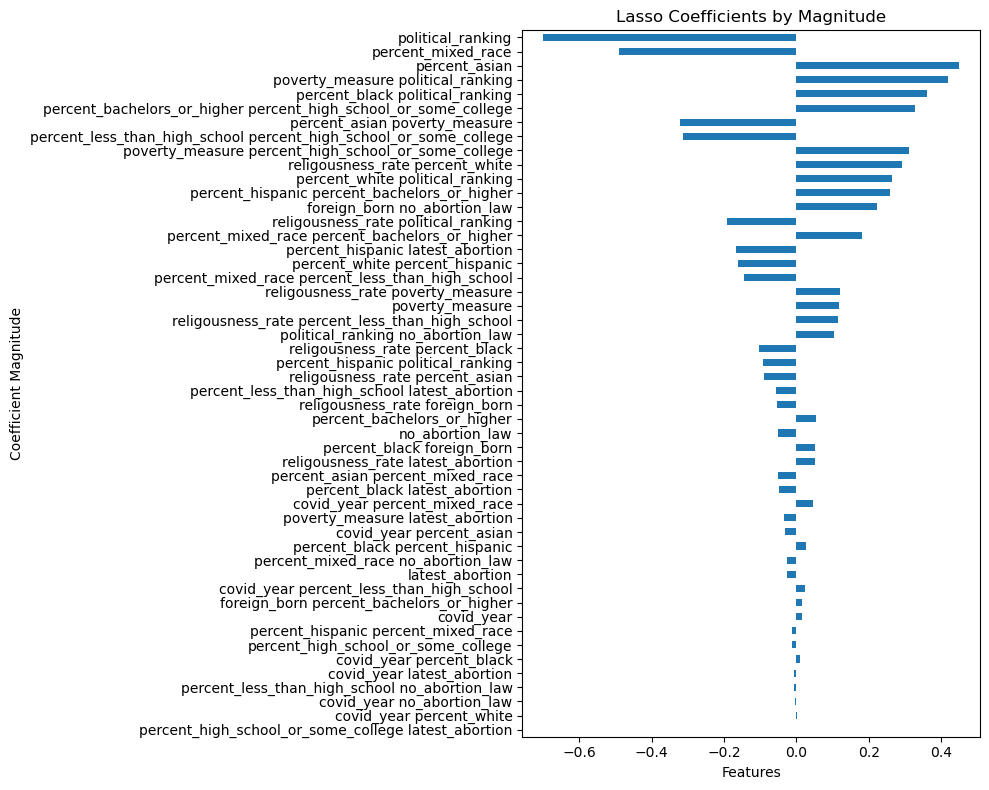

In [78]:
plt.figure(figsize=(10, 8))
largest_coefficients.sort_values(key=np.abs, ascending=True).plot(kind='barh')
plt.title("Lasso Coefficients by Magnitude")
plt.xlabel("Features")
plt.ylabel("Coefficient Magnitude")
plt.tight_layout()
plt.show()

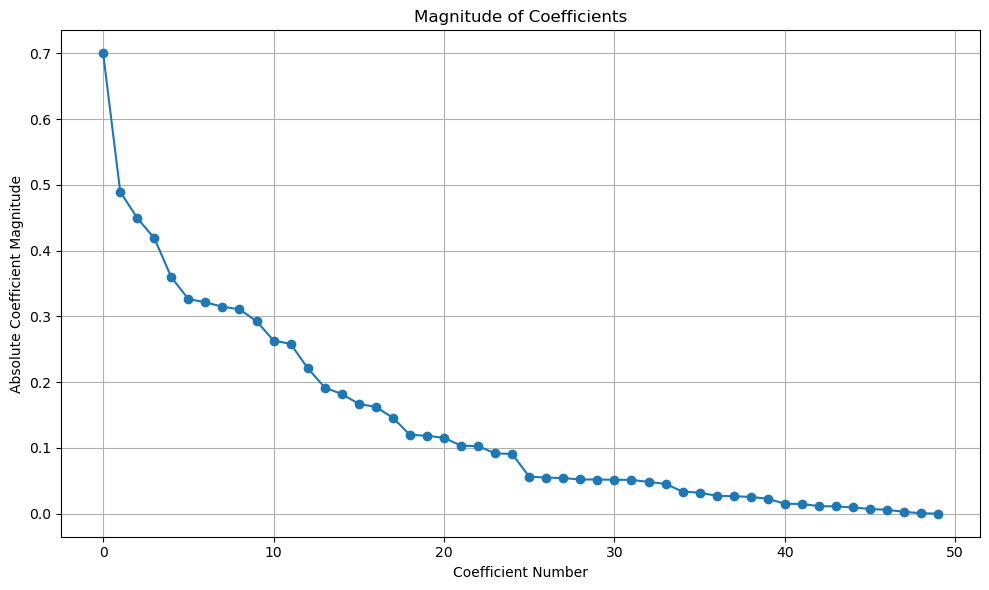

In [91]:
plt.figure(figsize=(10, 6))
largest_coefficients_abs = largest_coefficients.abs().sort_values(ascending=False)
plt.plot(largest_coefficients_abs.values, marker='o')
plt.title("Magnitude of Coefficients")
plt.xlabel("Coefficient Number")
plt.ylabel("Absolute Coefficient Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
lasso_cv_scores = cross_val_score(lasso_model, X_train_interactions_df, y_train, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(lasso_model, X_train_interactions_df, y_train, cv=5, scoring='r2')

print("Lasso CV Mean MSE:", -np.mean(lasso_cv_scores), ", R2 CV Mean:", np.mean(r2_scores))

Lasso CV Mean MSE: 0.14717677524919515 , R2 CV Mean: 0.829183548210794


This model is clearly much more accurate with a much lower MSE and higher R2

Now I want to test on my test data

In [89]:
y_test_pred_lasso = lasso_model.predict(X_test_interactions_df)
lasso_mse = mean_squared_error(y_test, y_test_pred_lasso)
lasso_r2 = r2_score(y_test, y_test_pred_lasso)

print("Test MSE:", lasso_mse, ", Test R2:", lasso_r2)

Test MSE: 0.11562564312669876 , Test R2: 0.8880357933628634


Our MSE and R2 are even better! This is not a fluke.

## Interpret the results: (Isabella)

Analyze the results of the model and communicate the findings. This may involve creating visualizations or presenting the results in a clear and concise manner. The findings here must lead to your choice of the final model.

**Say something about how well there are 50 significant predictors, the vast majority of the predicting is done by the first 20 or so**

## Final Model Pipeline: (Eliza)

 By this step, you should clearly understand and reason for choosing a particular machine learning technique. You are only expected to choose a technique and set up the pipeline to ensure that you are able to train it and run the required experiments. You are not required to tune your model to get optimal results.

**We will apply causal inference!**